# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Напишем небольшую функцию, чтобы сэкономить своё время и сделать код - легче для восприятия и чтения.

In [3]:
def summary(df):
    print(df.info()) 
    return df.head(10)

In [4]:
summary(df_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [5]:
summary(df_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [6]:
summary(df_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Проверим на дубли датасеты. 

In [7]:
print(df_0.duplicated().value_counts())
print(df_1.duplicated().value_counts())
print(df_2.duplicated().value_counts())

False    100000
dtype: int64
False    100000
dtype: int64
False    100000
dtype: int64


Когда изучаешь скважины - думай как скважина, поэтому углубляемся: проверим нет ли разных данных об одной и той же скважине.

In [8]:
print(df_0['id'].value_counts().head())
print(df_1['id'].value_counts().head())
print(df_2['id'].value_counts().head())

A5aEY    2
74z30    2
fiKDv    2
Tdehs    2
bsk9y    2
Name: id, dtype: int64
wt4Uk    2
5ltQ6    2
bfPNe    2
LHZR0    2
tiwtV    1
Name: id, dtype: int64
xCHr8    2
Vcm5J    2
VF7Jo    2
KUPhW    2
ySirA    1
Name: id, dtype: int64


In [9]:
print(df_0.query('id == "TtcGQ"'))

          id        f0        f1        f2     product
60140  TtcGQ  0.569276 -0.104876  6.440215   85.350186
92341  TtcGQ  0.110711  1.022689  0.911381  101.318008


In [10]:
print(df_1.query('id == "wt4Uk"'))

          id         f0        f1        f2     product
47591  wt4Uk  -9.091098 -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305


In [11]:
print(df_2.query('id == "Vcm5J"'))

          id        f0        f1        f2     product
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572


Видим, что у одинаковых айдишников - разные показатели. Как так получилось, один вопрос, скорее всего это произошло из-за того, что данные - синтетические. Другой вопрос: таких недублей-дублей немного, их можно смело удалить ради чистоты и корректности данных. 

In [12]:
def remove_double (data):
    names = data['id'].value_counts().reset_index()
    unique_names = names.query('id == 1')['index'].to_list()
    data.query('id in @unique_names', inplace=True)

In [13]:
remove_double(df_0)
remove_double(df_1)
remove_double(df_2)

Проверяем на пропуски:

In [14]:
df_0.isnull().sum()
df_1.isnull().sum()
df_2.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

С подозрительными данными разобрались, теперь удаляем столбец с id, он нам не понадобится в дальнейшем. Плюс, они могут конфузить будущую модель машинного обучения.

In [15]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

# 2. Обучение и проверка модели

В задаче было указано, что для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые), её и будем использовать.

In [16]:
model = LinearRegression()

Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25, обучим модель и сделаем предсказания на валидационной выборке. Заворачиваем это всё в функцию.

In [17]:
def get_predictions_target (data):
    features = data.drop(['product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=666)
    model.fit(features_train, target_train)
    return pd.Series(model.predict(features_valid)), target_valid

Сохраним предсказания и правильные ответы на валидационной выборке.

In [19]:
predicted_0, target_0 = get_predictions_target(df_0)

In [20]:
predicted_1, target_1 = get_predictions_target(df_1)

In [21]:
predicted_2, target_2 = get_predictions_target(df_2)

Выводим на экране средний запас предсказанного сырья и RMSE модели.

In [22]:
def get_mean_product_and_rmse (answers, predictions):
    mse = mean_squared_error(answers, predictions)
    print('Средний запас сырья, тыс. баррелей:', predictions.mean())
    print('RMSE:', mse ** 0.5)

In [23]:
print('Регион 1')
get_mean_product_and_rmse(target_0, predicted_0)

Регион 1
Средний запас сырья, тыс. баррелей: 92.51122396649589
RMSE: 37.51264378666752


In [24]:
print('Регион 2')
get_mean_product_and_rmse(target_1, predicted_1)

Регион 2
Средний запас сырья, тыс. баррелей: 68.84582277575738
RMSE: 0.8893533318289


In [25]:
print('Регион 3')
get_mean_product_and_rmse(target_2, predicted_2)

Регион 3
Средний запас сырья, тыс. баррелей: 95.18962000390482
RMSE: 40.00784454122081


Вывод: Регион 2 оказался самым скудным по среднему запасу сырья на скважину - 68.9, меньше остальных регионов на 30 единиц миниум, но модель построенная для данного региона предсказывает объем сырья на скважине лучше всех с показателем RMSE в 0.92 против практически 40 у других двух регионов. Регионы 1 и 3 являются самыми рисковыми, так как их модели обладают большими RMSE, но также и самими богатыми, так как средний запас сырья на скажине превышает значение в 90 баррелей.

# 3. Подготовка к расчёту прибыли

In [26]:
budget = 10000000000
oil_wells_number = 200
budget_for_one = budget / oil_wells_number
revenue_rub = 450000
max_risk = 0.025
mlrd = 1000000000
cost_one_oilwell = 50000000

Расчитаем сколько в среднем должны приносить 200 лучших скважин в регионе, чтобы добыча была безубыточной:

In [27]:
min_product = budget_for_one / revenue_rub
print("Достаточный объём сырья для безубыточной разработки новой скважины {:.2f}".format(min_product))

Достаточный объём сырья для безубыточной разработки новой скважины 111.11


Выходит, что ни один регион по предвраительному анализу не дотягивает до достаточного объёма сырья, который обеспечит прибыльный проект бурения скважины: 111 против 95, 92 и 68.

# 4. Расчёт прибыли и рисков 

Пишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [28]:
def revenue(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:oil_wells_number]
    return ((revenue_rub * selected.sum()) - budget) / mlrd

In [29]:
print('Прибыль 200 скважин первого региона {:,.2f} млрд руб'.format(revenue(target_0, predicted_0)))

Прибыль 200 скважин первого региона 3.14 млрд руб


In [30]:
print('Прибыль 200 скважин второго региона {:,.2f} млрд руб'.format(revenue(target_1, predicted_1)))

Прибыль 200 скважин второго региона 2.42 млрд руб


In [31]:
print('Прибыль 200 скважин третьего региона {:,.2f} млрд руб'.format(revenue(target_2, predicted_2)))

Прибыль 200 скважин третьего региона 2.13 млрд руб


На данном этапе самым прибыльным регионом можно считать первый - более 3 млрд рублей, но держим в уме, что самые точные предсказания модели были по второму региону, он остаётся более стабильным в показателях.

In [32]:
state = np.random.RandomState(12345)

In [33]:
def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample)
        values.append(rev)

    values = pd.Series(values)
    lower = np.quantile(values, 0.025)
    upper = np.quantile(values, 0.975)
    mean = values.mean()

    print("Средняя выручка:", mean)
    print("Нижняя граница доверительного интервала: {:,.2f} руб.", lower)
    print("Верхняя граница доверительного интервала: {:,.2f} руб.", upper)
    print("Риски убытка:", (values < 0).mean())

In [34]:
print('Регион 1:')
bootstrap(target_0, predicted_0)

Регион 1:
Средняя выручка: 0.4035191342664812
Нижняя граница доверительного интервала: {:,.2f} руб. -0.07639114484337263
Верхняя граница доверительного интервала: {:,.2f} руб. 0.9144185697016467
Риски убытка: 0.055


In [35]:
print('Регион 2:')
bootstrap(target_1, predicted_1)

Регион 2:
Средняя выручка: 0.425277896119325
Нижняя граница доверительного интервала: {:,.2f} руб. -0.003214826254179571
Верхняя граница доверительного интервала: {:,.2f} руб. 0.821803760643534
Риски убытка: 0.027


In [36]:
print('Регион 3:')
bootstrap(target_2, predicted_2)

Регион 3:
Средняя выручка: 0.32269615314288136
Нижняя граница доверительного интервала: {:,.2f} руб. -0.1884059867797857
Верхняя граница доверительного интервала: {:,.2f} руб. 0.8535345171200671
Риски убытка: 0.117


После анализа рисков убытка и средней выручки, а также вообще исследования нашим заключением будет выбор в пользу второй скважины. Почему? Точность предсказания модели показывала самый высокий показатель у второй скважины. Да, конечно, можно возразить, что прибыль 200 скважин первого района показывает самую большую выручку - 3.14 VS 2.42. Однако, взвешенным решением в данной ситуации будет бурение скважин в регионе с самыми стабильными и, что важно, предсказуемыми результатами, которые нам удалось эмулировать с помощью машинного обучения. Котейка рубль бережёт!

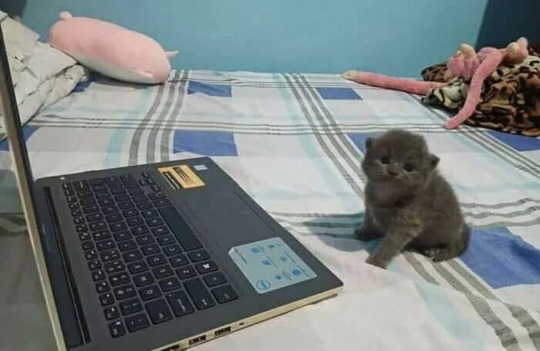